In [1]:
!nvidia-smi

Tue Jun  2 20:04:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install -q -U watermark


In [3]:
!pip install -qq transformers

     |████████████████████████████████| 675kB 8.2MB/s 
     |████████████████████████████████| 1.1MB 19.6MB/s 
     |████████████████████████████████| 3.8MB 57.3MB/s 
     |████████████████████████████████| 890kB 61.4MB/s 


In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.4
pandas 1.0.4
torch 1.5.0+cu101
transformers 2.11.0


In [5]:
#imports
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
!wget -O data.csv https://raw.githubusercontent.com/tushar1210/Emotional-Anlaysis-BERT/master/data.csv?token=AFCBJTYYIMZSUMMD5SQTRK2632J7S

--2020-06-02 20:04:48--  https://raw.githubusercontent.com/tushar1210/Emotional-Anlaysis-BERT/master/data.csv?token=AFCBJTYYIMZSUMMD5SQTRK2632J7S
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977654 (955K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 954.74K  --.-KB/s    in 0.03s   

2020-06-02 20:04:49 (31.7 MB/s) - ‘data.csv’ saved [977654/977654]



In [0]:
df = pd.read_csv('data.csv')

In [0]:
df = df.drop('Unnamed: 0', 1)

In [0]:
enc_classes={'joy':0,'fear':1,'anger':2,'sadness':3,'digust':2,'shame':3,'guilty':3}
class_name=['joy','fear','anger','sadness']

def to_number(emotion):
  emotion=str(emotion)
  return enc_classes[emotion]

df['Enc_Emotion'] = df.Emotion.apply(to_number)



In [10]:
df=df.drop('Emotion',1)
df[:8]

,Sentence,Enc_Emotion
0,"During the period of falling in love, each tim...",0
1,When I was involved in a traffic accident.,1
2,When I was driving home after several days of...,2
3,When I lost the person who meant the most to me.,3
4,The time I knocked a deer down - the sight of ...,2
5,When I did not speak the truth.,3
6,When I caused problems for somebody because he...,3
7,When I got a letter offering me the Summer job...,0


In [11]:
df.shape

(7666, 2)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7666 entries, 0 to 7665
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sentence     7666 non-null   object
 1   Enc_Emotion  7666 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.9+ KB


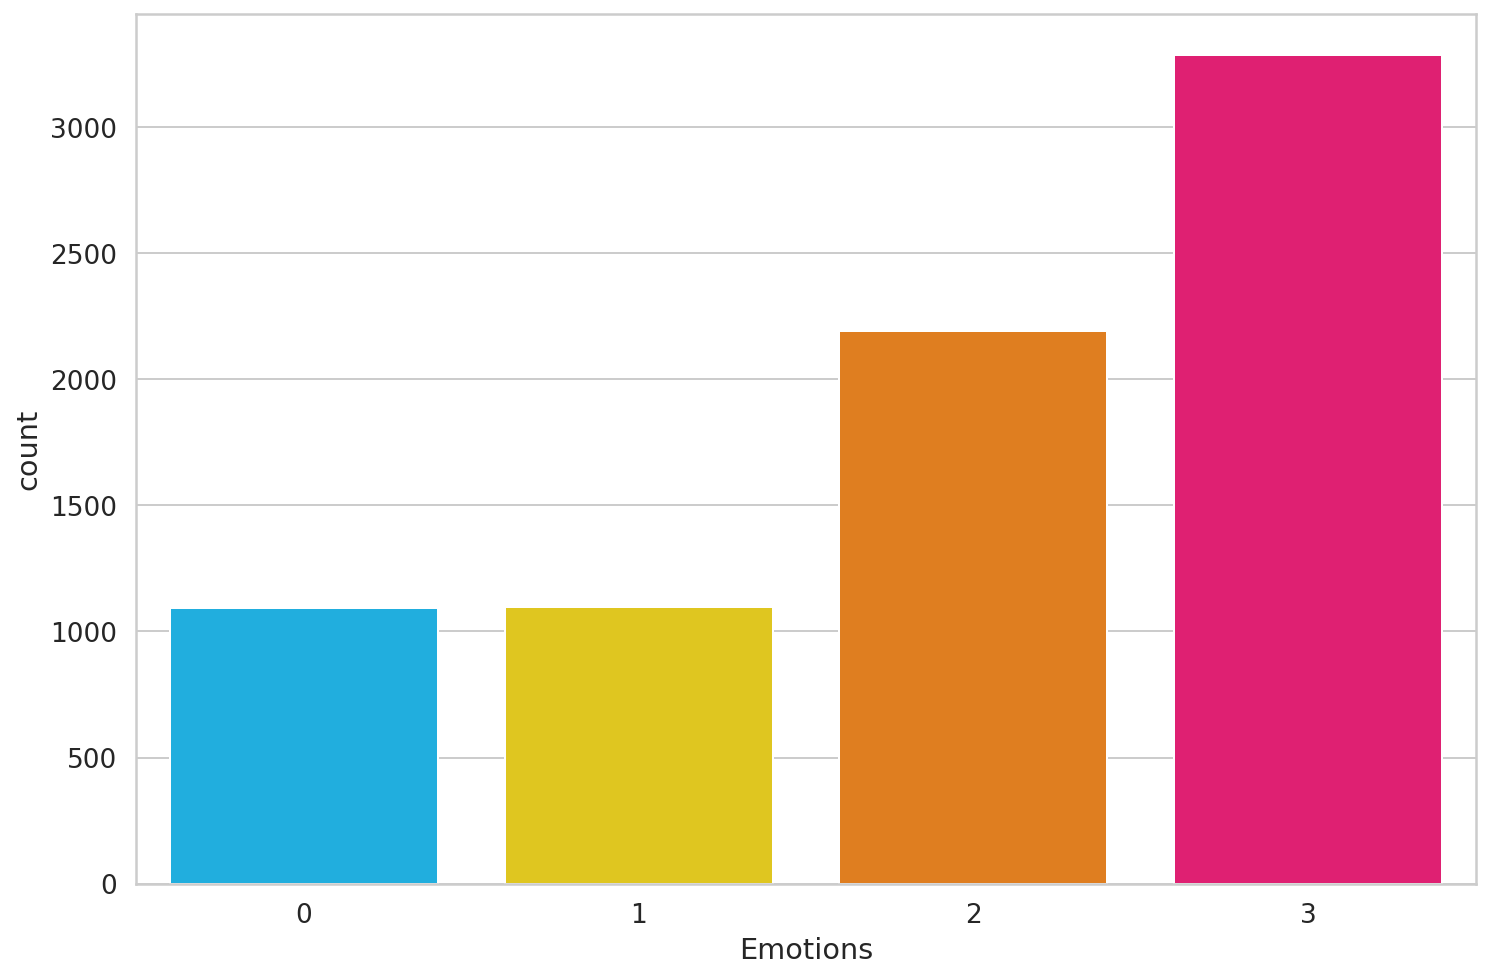

In [13]:
sns.countplot(df.Enc_Emotion)
plt.xlabel('Emotions');



```
`# This is formatted as code`
```

Data is not balanced

In [0]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [15]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [16]:
#SEP TOKEN : marker for ending of a sentence
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [17]:
#CLS TOKEN : we must add this token to the start of each sentence, so BERT knows we're doing classification
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [18]:
#PAD Token: for padding
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [19]:
#UNK : Unknown Token
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [20]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [21]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [22]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [23]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [0]:
token_lens = []

for txt in df.Sentence:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

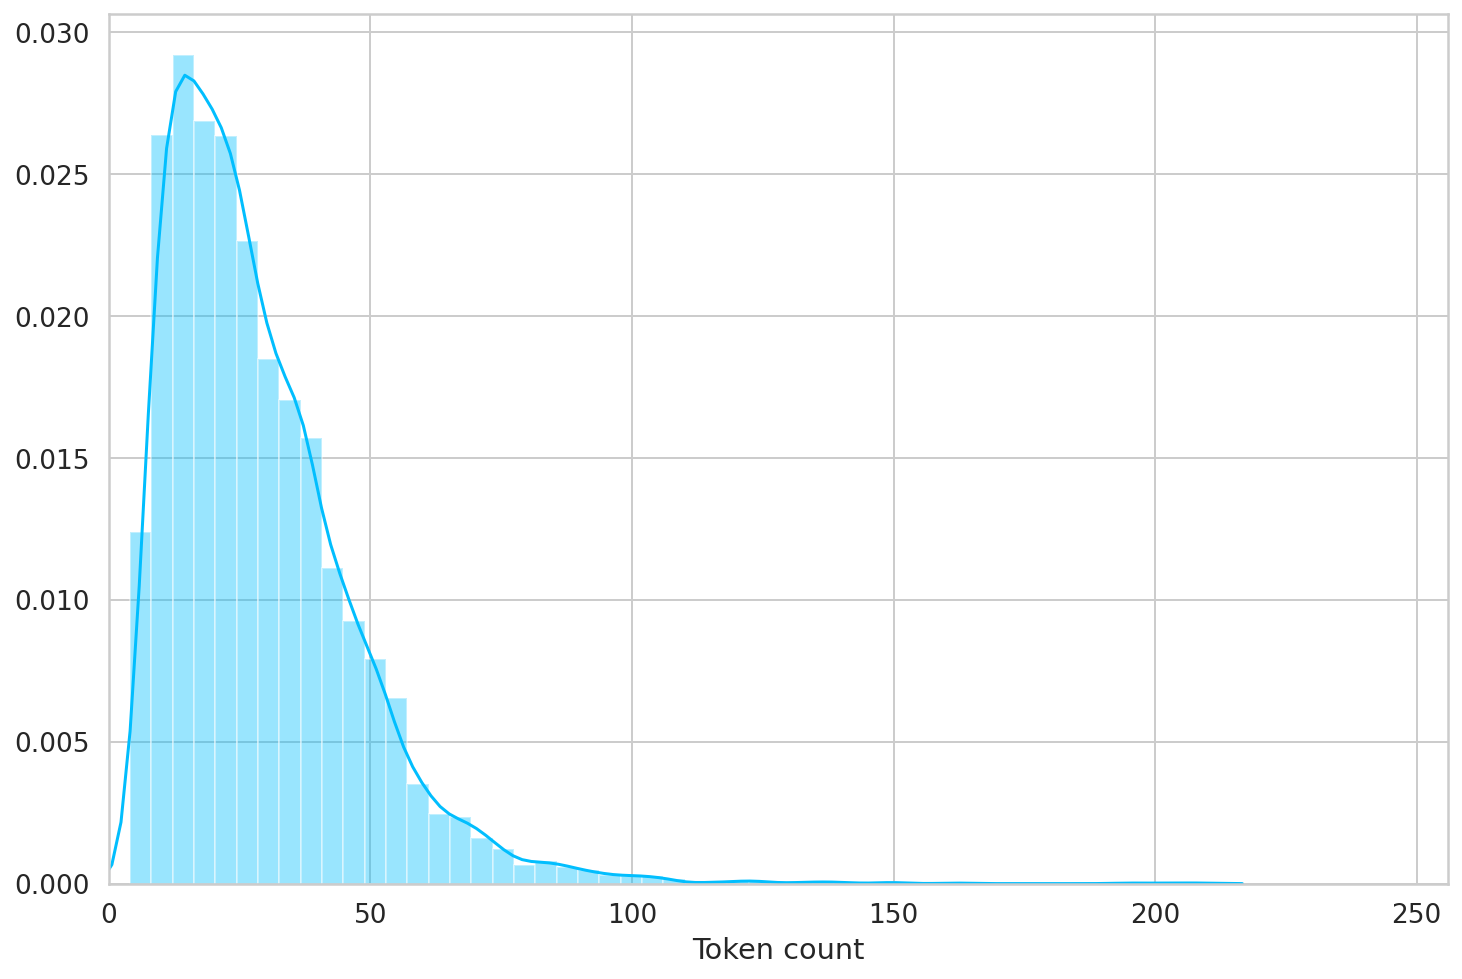

In [25]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [0]:
MAX_LEN = 130

In [0]:
class EmotionReviewDataSet(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [0]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)


In [29]:
df_train.shape, df_val.shape, df_test.shape

((6899, 2), (383, 2), (384, 2))

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = EmotionReviewDataSet(
    reviews=df.Sentence.to_numpy(),
    targets=df.Enc_Emotion.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [0]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [32]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [33]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 130])
torch.Size([16, 130])
torch.Size([16])


In [34]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [36]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [37]:
bert_model.config.hidden_size

768

In [38]:
pooled_output.shape

torch.Size([1, 768])

In [0]:
class EmotionClassifier(nn.Module):

  def __init__(self, n_classes):
    super(EmotionClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [0]:
torch.cuda.empty_cache()

In [0]:
model = EmotionClassifier(len(class_name))
model = model.to(device)

In [42]:
print(model)

EmotionClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [43]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 130])
torch.Size([16, 130])


In [44]:
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3341, 0.1539, 0.3396, 0.1724],
        [0.4183, 0.1137, 0.2905, 0.1775],
        [0.2038, 0.1106, 0.5386, 0.1471],
        [0.4866, 0.0976, 0.2823, 0.1335],
        [0.5031, 0.1521, 0.1942, 0.1506],
        [0.2754, 0.1436, 0.4242, 0.1569],
        [0.3596, 0.0925, 0.4182, 0.1297],
        [0.2619, 0.2282, 0.3530, 0.1569],
        [0.2699, 0.1330, 0.4752, 0.1219],
        [0.1924, 0.1746, 0.4382, 0.1948],
        [0.3365, 0.1530, 0.3404, 0.1701],
        [0.3445, 0.1934, 0.3530, 0.1091],
        [0.4035, 0.0616, 0.2998, 0.2352],
        [0.3836, 0.1153, 0.3048, 0.1962],
        [0.3084, 0.1199, 0.3698, 0.2019],
        [0.2950, 0.1523, 0.3962, 0.1565]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [0]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False, weight_decay=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [0]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [48]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7628910427361175 accuracy 0.6934338309899986
Val   loss 0.4820177884151538 accuracy 0.8276762402088773

Epoch 2/10
----------
Train loss 0.3554427704926908 accuracy 0.8721553848383824
Val   loss 0.4571715264270703 accuracy 0.8590078328981723

Epoch 3/10
----------
Train loss 0.2016812216569195 accuracy 0.936802435135527
Val   loss 0.6120290451993545 accuracy 0.8459530026109661

Epoch 4/10
----------
Train loss 0.11624040106808362 accuracy 0.9670966806783592
Val   loss 0.7059329152107239 accuracy 0.8407310704960835

Epoch 5/10
----------
Train loss 0.08568709813941193 accuracy 0.9775329757935933
Val   loss 0.8060564088324705 accuracy 0.8433420365535248

Epoch 6/10
----------
Train loss 0.051819304987374276 accuracy 0.9866647340194231
Val   loss 0.8870951154579719 accuracy 0.835509138381201

Epoch 7/10
----------
Train loss 0.03825638812890651 accuracy 0.9888389621684303
Val   loss 0.8332076274479429 accuracy 0.8511749347258486

Epoch 8/10
----------
Tr

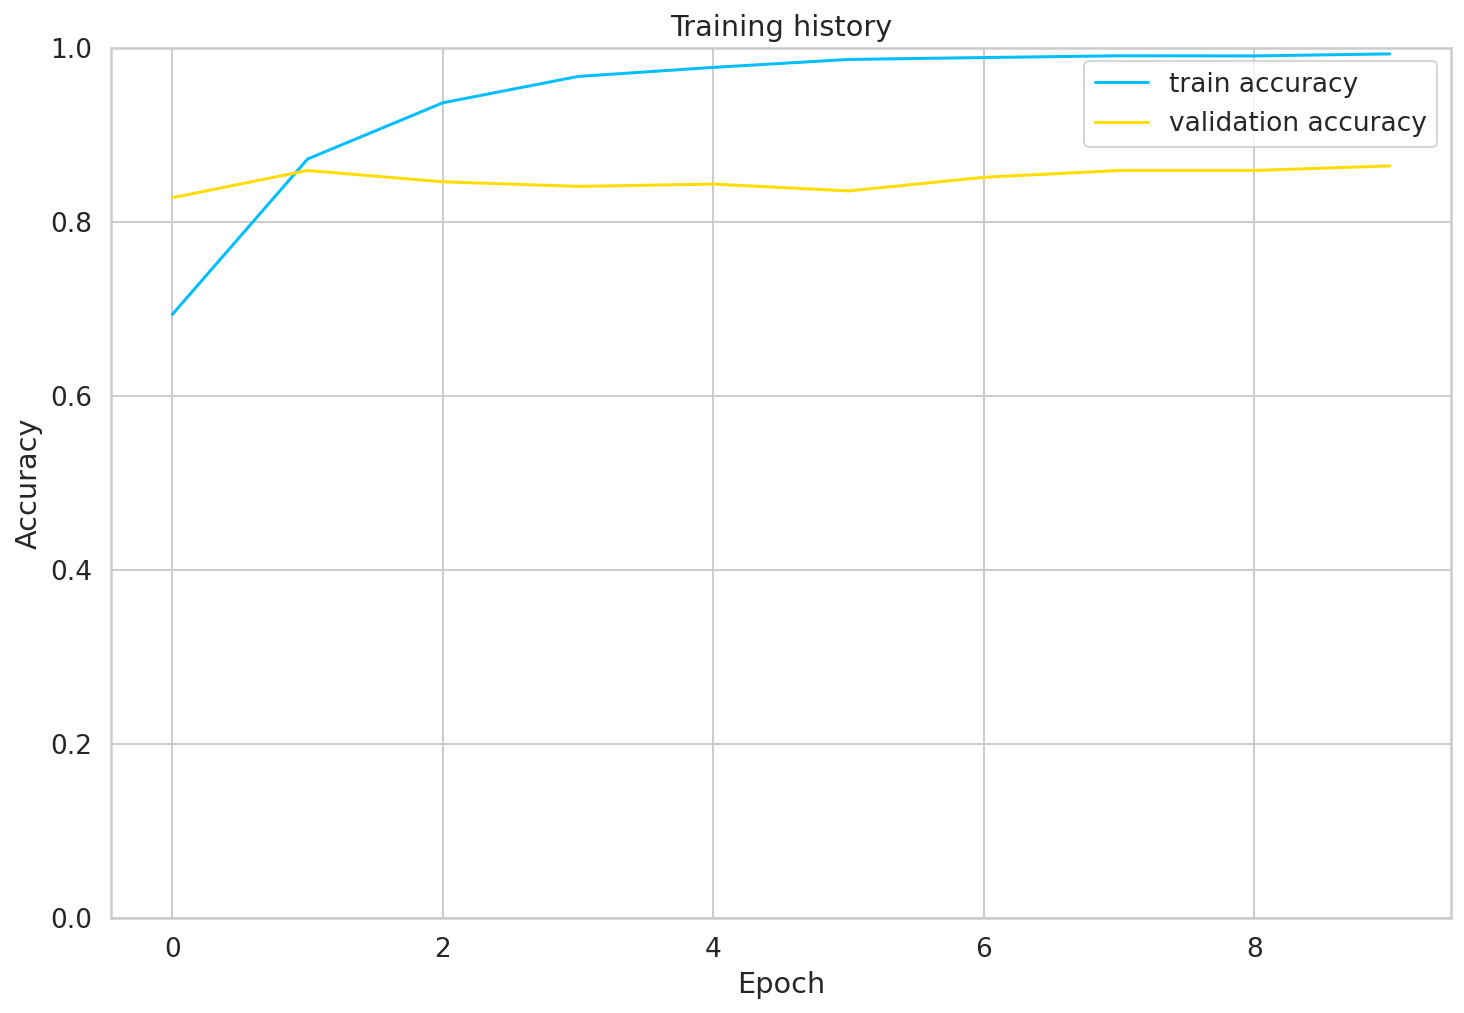

In [49]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [50]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7994791666666666

In [0]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [0]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [53]:
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

         joy       0.88      0.93      0.91        57
        fear       0.78      0.77      0.78        61
       anger       0.78      0.67      0.72       105
     sadness       0.79      0.85      0.82       161

    accuracy                           0.80       384
   macro avg       0.81      0.80      0.80       384
weighted avg       0.80      0.80      0.80       384



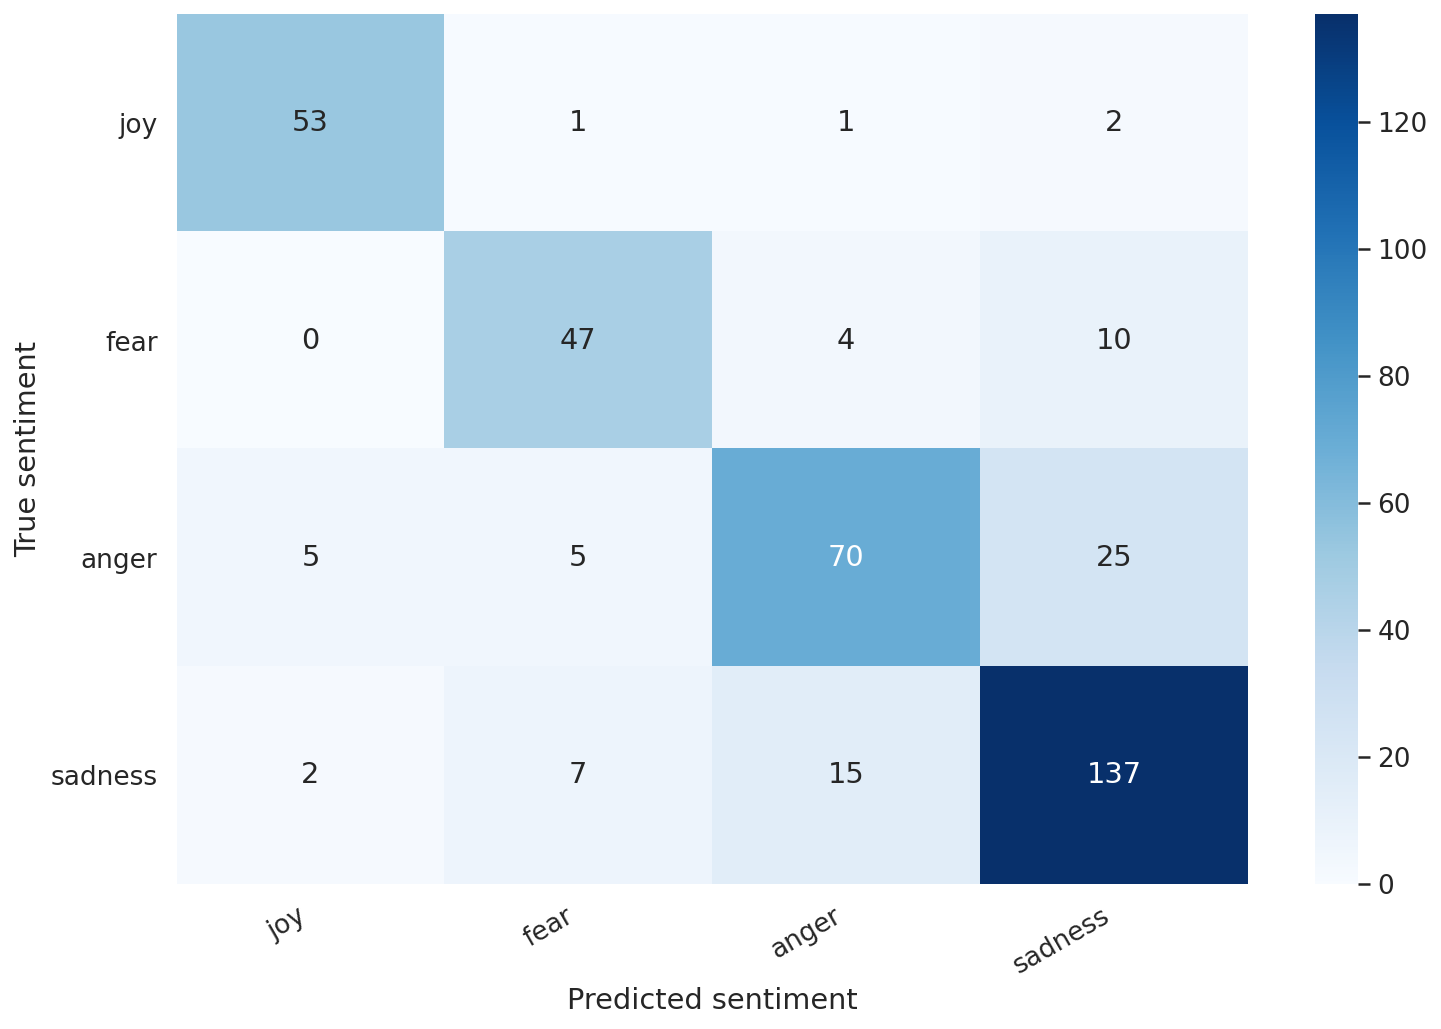

In [54]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

In [0]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_name,
  'values': y_pred_probs[idx]
})

In [56]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_name[true_sentiment]}')

A class-mate died after being two months in coma, after a car á
accident.

True sentiment: sadness


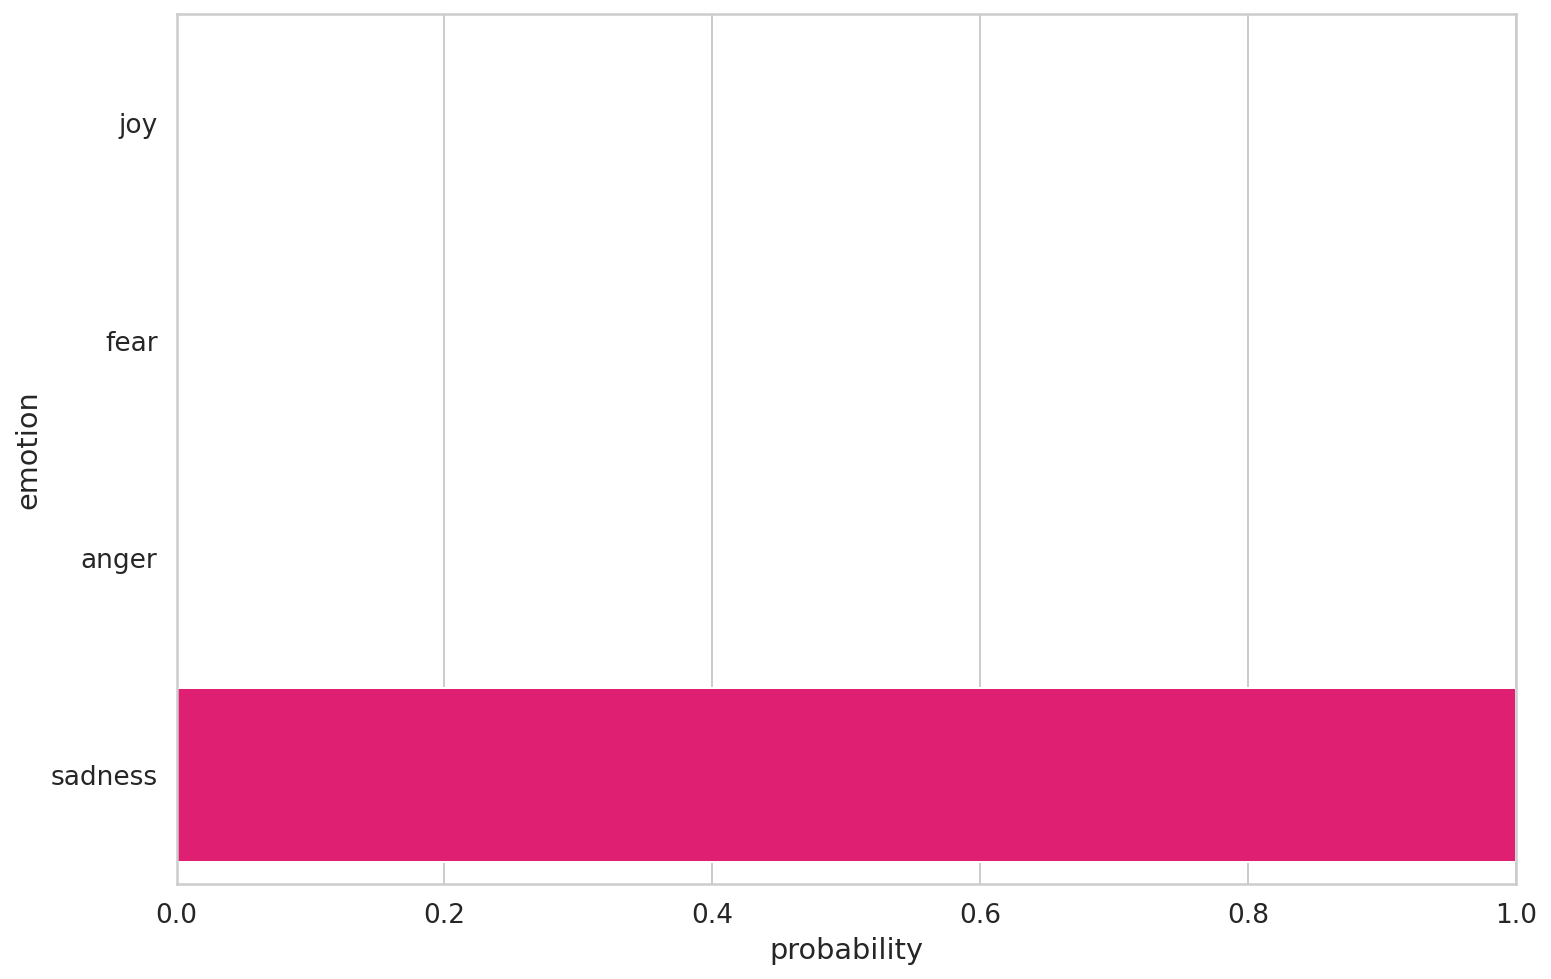

In [57]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('emotion')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [0]:
review_text = "I am dissapointed by my new car's performance and it was so expensive! "

In [0]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [69]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_name[prediction]}')

Review text: I am dissapointed by my new car's performance and it was so expensive! 
Sentiment  : anger
